# Final project: Hard drive failure clasification and anomaly detection 
---
### Description: 
Alumno: Iñaki Sebastián Orozco García

Matrícula: is719276

Materia: Aprendizaje automático

Maestro: Iván Reyes Amezcua

Fecha: 11/13/2024


Libraries going to be used

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import os
import multiprocessing
from sklearn import tree
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2  

os.environ['LOKY_MAX_CPU_COUNT'] = str(multiprocessing.cpu_count())

# Dataset with all attributes

Loaded full dataset for 10 span to explore different methods with all the attributes

In [3]:
def import_data_from_csv(folder_path):
    df = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv") and file_name.startswith("2024-07-0"):
            print(file_name)
            file_path = os.path.join(folder_path, file_name)
            temp_df = pd.read_csv(file_path)
            columns_to_delete = ['date', 'serial_number', 'model', 'capacity_bytes', 'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format']
            temp_df = temp_df.drop(columns=columns_to_delete)
            df = pd.concat([df, temp_df], ignore_index=True)
    return df

folder_path = '../data/external/data_Q3_2024'
df = import_data_from_csv(folder_path)
df = df.fillna(0)
print(df.head())

2024-07-01.csv
2024-07-02.csv
2024-07-03.csv
2024-07-04.csv
2024-07-05.csv
2024-07-06.csv
2024-07-07.csv
2024-07-08.csv
2024-07-09.csv
   failure  smart_1_normalized  smart_1_raw  smart_2_normalized  smart_2_raw  \
0        0               100.0          0.0               133.0        105.0   
1        0               100.0          0.0               134.0        102.0   
2        0               100.0         63.0               252.0          0.0   
3        0               120.0  243838384.0                 0.0          0.0   
4        0               114.0   76159736.0                 0.0          0.0   

   smart_3_normalized  smart_3_raw  smart_4_normalized  smart_4_raw  \
0               130.0        535.0               100.0         15.0   
1               128.0        541.0               100.0         25.0   
2                94.0       2020.0               100.0         20.0   
3                92.0          0.0               100.0         17.0   
4                91.0        

### Anomaly Detection using Isolation Forest

We want at least the failed drives to be 0.1% to have the contamination of the IsolationForest to look for that .1% of outliers, we will balance the df to reach that percentage

In [4]:
# Calculate the number of failure and non-failure samples needed
num_failures = df['failure'].sum()
num_non_failures_needed = int(num_failures / 0.001) - num_failures

# Sample the required number of non-failure samples
non_failures_sampled = df[df['failure'] == 0].sample(n=num_non_failures_needed, random_state=42)

# Combine the failure and sampled non-failure samples
df_balanced = pd.concat([df[df['failure'] == 1], non_failures_sampled])

# Shuffle the dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


failure_counts = df_balanced['failure'].value_counts(normalize=True) * 100

print(failure_counts)

failure
0    99.9
1     0.1
Name: proportion, dtype: float64


In [5]:

iso_forest = IsolationForest(contamination=failure_counts[1], random_state=42)

# Fit the model on the original data (excluding the 'failure' column)
iso_forest.fit(df_balanced.drop(columns=['failure']))

# Predict anomalies
anomalies = iso_forest.predict(df.drop(columns=['failure']))

# Convert anomalies to boolean (1 for anomaly, -1 for normal)
anomalies = anomalies == -1

# Compare anomalies with failed drives
comparison = pd.DataFrame({'Anomaly': anomalies, 'Failure': df['failure']})

# Print the comparison
print(comparison.value_counts())

Anomaly  Failure
False    0          2336618
True     0           263858
False    1               65
True     1               58
Name: count, dtype: int64


We can see that in this case the failed drives don't fit into an 'outlier' category, this drives are not presenting out of the ordinary S.M.A.R.T attributes data and they can't be detected correctly with Isolation Forest having a negative accuracy.

## Identify useful features

### Correlation matrix with heatmap

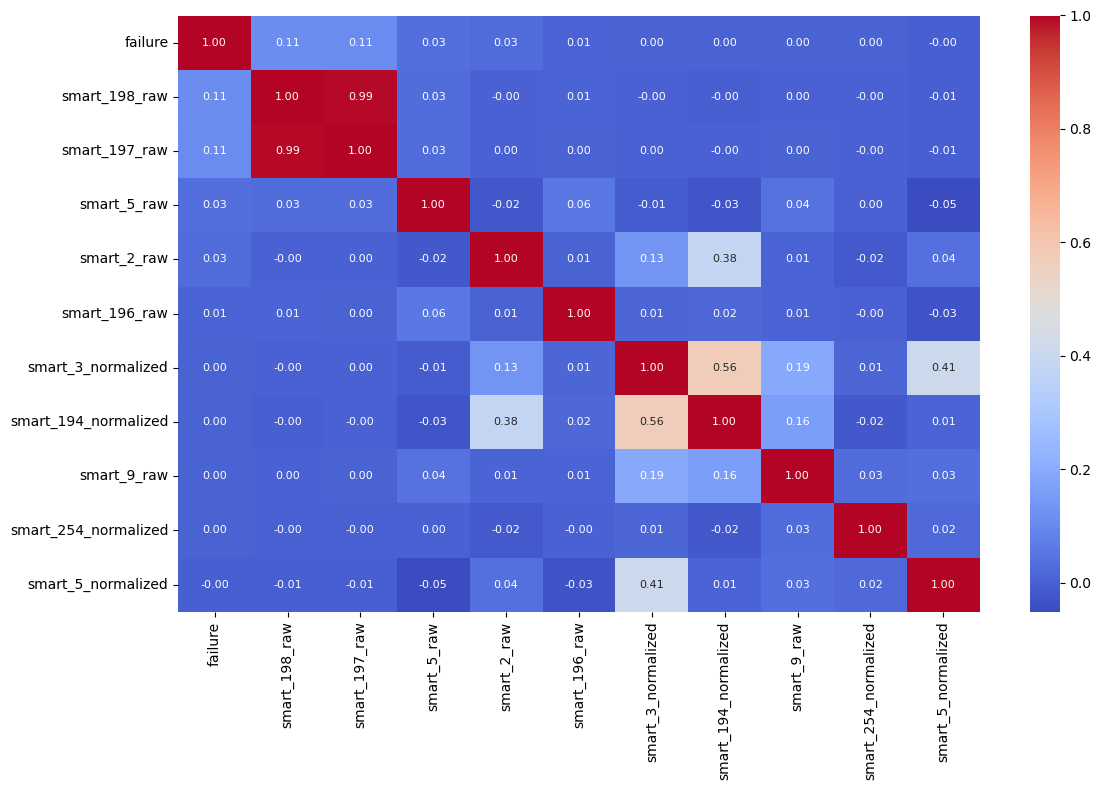

In [34]:
correlation_matrix = df.corr()

# Select top 10 features with highest correlation to the target variable
features = correlation_matrix['failure'].abs().sort_values(ascending=False).head(11)
reduced_corr_matrix = correlation_matrix.loc[features.index, features.index]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(reduced_corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8}, fmt='.2f')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_heatmap.png')
plt.show()

### Univariate Feature Selection

In [12]:
X = df.drop(columns=['failure'])
y = df['failure']

In [32]:
selector = SelectKBest(score_func=chi2 , k=10)
X_new = selector.fit_transform(X, y)


KB_f = selector.get_support(indices=True)
selected_feature_names = X.columns[KB_f]
print(selected_feature_names)

Index(['smart_7_raw', 'smart_90_raw', 'smart_165_raw', 'smart_173_raw',
       'smart_188_raw', 'smart_230_raw', 'smart_231_raw', 'smart_232_raw',
       'smart_235_raw', 'smart_242_raw'],
      dtype='object')


In [36]:
C_M_features = [df.columns.get_loc(col) for col in features.index]
print(C_M_features)
KBest_features = KB_f.tolist()
print(KBest_features)
S_O_T_A_features = [1, 3, 5, 7, 9, 187, 189, 190, 195, 197] #this are the attributes used in the state of the art
print(S_O_T_A_features)

[0, 118, 116, 10, 4, 114, 5, 109, 16, 183, 9]
[11, 45, 55, 71, 97, 149, 151, 153, 159, 165]
[1, 3, 5, 7, 9, 187, 189, 190, 195, 197]


# Hard drive failure clasification using Decision Trees

### Using Dataset attributes from state of the art

Code to convert the dataset into a df, we have to be careful because the dataset has a lot of values and the df can take a lot of space unnecesarily

In [80]:
def process_chunks(file_path):
    chunksize = 10 ** 6
    dtype_dict = {'date': 'str', 'serial_number': 'str', 'model': 'str', 'capacity_bytes': 'int32', 'failure': 'bool', 'datacenter': 'str', 'cluster_id': 'int8', 'vault_id': 'int16', 'pod_id': 'int16', 'pod_slot_num': 'float32', 'is_legacy_format': 'bool', 'smart_1_normalized': 'float64', 'smart_1_raw': 'float64', 'smart_2_normalized': 'float64', 'smart_2_raw': 'float64', 'smart_3_normalized': 'float64', 'smart_3_raw': 'float64', 'smart_4_normalized': 'float64', 'smart_4_raw': 'float64', 'smart_5_normalized': 'float64', 'smart_5_raw': 'float64', 'smart_7_normalized': 'float64', 'smart_7_raw': 'float64', 'smart_8_normalized': 'float64', 'smart_8_raw': 'float64', 'smart_9_normalized': 'float64', 'smart_9_raw': 'float64', 'smart_10_normalized': 'float64', 'smart_10_raw': 'float64', 'smart_11_normalized': 'float64', 'smart_11_raw': 'float64', 'smart_12_normalized': 'float64', 'smart_12_raw': 'float64', 'smart_13_normalized': 'float64', 'smart_13_raw': 'float64', 'smart_15_normalized': 'float64', 'smart_15_raw': 'float64', 'smart_16_normalized': 'float64', 'smart_16_raw': 'float64', 'smart_17_normalized': 'float64', 'smart_17_raw': 'float64', 'smart_18_normalized': 'float64', 'smart_18_raw': 'float64', 'smart_22_normalized': 'float64', 'smart_22_raw': 'float64', 'smart_23_normalized': 'float64', 'smart_23_raw': 'float64', 'smart_24_normalized': 'float64', 'smart_24_raw': 'float64', 'smart_27_normalized': 'float64', 'smart_27_raw': 'float64', 'smart_71_normalized': 'float64', 'smart_71_raw': 'float64', 'smart_82_normalized': 'float64', 'smart_82_raw': 'float64', 'smart_90_normalized': 'float64', 'smart_90_raw': 'float64', 'smart_160_normalized': 'float64', 'smart_160_raw': 'float64', 'smart_161_normalized': 'float64', 'smart_161_raw': 'float64', 'smart_163_normalized': 'float64', 'smart_163_raw': 'float64', 'smart_164_normalized': 'float64', 'smart_164_raw': 'float64', 'smart_165_normalized': 'float64', 'smart_165_raw': 'float64', 'smart_166_normalized': 'float64', 'smart_166_raw': 'float64', 'smart_167_normalized': 'float64', 'smart_167_raw': 'float64', 'smart_168_normalized': 'float64', 'smart_168_raw': 'float64', 'smart_169_normalized': 'float64', 'smart_169_raw': 'float64', 'smart_170_normalized': 'float64', 'smart_170_raw': 'float64', 'smart_171_normalized': 'float64', 'smart_171_raw': 'float64', 'smart_172_normalized': 'float64', 'smart_172_raw': 'float64', 'smart_173_normalized': 'float64', 'smart_173_raw': 'float64', 'smart_174_normalized': 'float64', 'smart_174_raw': 'float64', 'smart_175_normalized': 'float64', 'smart_175_raw': 'float64', 'smart_176_normalized': 'float64', 'smart_176_raw': 'float64', 'smart_177_normalized': 'float64', 'smart_177_raw': 'float64', 'smart_178_normalized': 'float64', 'smart_178_raw': 'float64', 'smart_179_normalized': 'float64', 'smart_179_raw': 'float64', 'smart_180_normalized': 'float64', 'smart_180_raw': 'float64', 'smart_181_normalized': 'float64', 'smart_181_raw': 'float64', 'smart_182_normalized': 'float64', 'smart_182_raw': 'float64', 'smart_183_normalized': 'float64', 'smart_183_raw': 'float64', 'smart_184_normalized': 'float64', 'smart_184_raw': 'float64', 'smart_187_normalized': 'float64', 'smart_187_raw': 'float64', 'smart_188_normalized': 'float64', 'smart_188_raw': 'float64', 'smart_189_normalized': 'float64', 'smart_189_raw': 'float64', 'smart_190_normalized': 'float64', 'smart_190_raw': 'float64', 'smart_191_normalized': 'float64', 'smart_191_raw': 'float64', 'smart_192_normalized': 'float64', 'smart_192_raw': 'float64', 'smart_193_normalized': 'float64', 'smart_193_raw': 'float64', 'smart_194_normalized': 'float64', 'smart_194_raw': 'float64', 'smart_195_normalized': 'float64', 'smart_195_raw': 'float64', 'smart_196_normalized': 'float64', 'smart_196_raw': 'float64', 'smart_197_normalized': 'float64', 'smart_197_raw': 'float64', 'smart_198_normalized': 'float64', 'smart_198_raw': 'float64', 'smart_199_normalized': 'float64', 'smart_199_raw': 'float64', 'smart_200_normalized': 'float64', 'smart_200_raw': 'float64', 'smart_201_normalized': 'float64', 'smart_201_raw': 'float64', 'smart_202_normalized': 'float64', 'smart_202_raw': 'float64', 'smart_206_normalized': 'float64', 'smart_206_raw': 'float64', 'smart_210_normalized': 'float64', 'smart_210_raw': 'float64', 'smart_218_normalized': 'float64', 'smart_218_raw': 'float64', 'smart_220_normalized': 'float64', 'smart_220_raw': 'float64', 'smart_222_normalized': 'float64', 'smart_222_raw': 'float64', 'smart_223_normalized': 'float64', 'smart_223_raw': 'float64', 'smart_224_normalized': 'float64', 'smart_224_raw': 'float64', 'smart_225_normalized': 'float64', 'smart_225_raw': 'float64', 'smart_226_normalized': 'float64', 'smart_226_raw': 'float64', 'smart_230_normalized': 'float64', 'smart_230_raw': 'float64', 'smart_231_normalized': 'float64', 'smart_231_raw': 'float64', 'smart_232_normalized': 'float64', 'smart_232_raw': 'float64', 'smart_233_normalized': 'float64', 'smart_233_raw': 'float64', 'smart_234_normalized': 'float64', 'smart_234_raw': 'float64', 'smart_235_normalized': 'float64', 'smart_235_raw': 'float64', 'smart_240_normalized': 'float64', 'smart_240_raw': 'float64', 'smart_241_normalized': 'float64', 'smart_241_raw': 'float64', 'smart_242_normalized': 'float64', 'smart_242_raw': 'float64', 'smart_244_normalized': 'float64', 'smart_244_raw': 'float64', 'smart_245_normalized': 'float64', 'smart_245_raw': 'float64', 'smart_246_normalized': 'float64', 'smart_246_raw': 'float64', 'smart_247_normalized': 'float64', 'smart_247_raw': 'float64', 'smart_248_normalized': 'float64', 'smart_248_raw': 'float64', 'smart_250_normalized': 'float64', 'smart_250_raw': 'float64', 'smart_251_normalized': 'float64', 'smart_251_raw': 'float64', 'smart_252_normalized': 'float64', 'smart_252_raw': 'float64', 'smart_254_normalized': 'float64', 'smart_254_raw': 'float64', 'smart_255_normalized': 'float64', 'smart_255_raw': 'float64'}
    aggregated_result = pd.DataFrame() 

    for chunk in pd.read_csv(file_path, chunksize=chunksize, dtype=dtype_dict):
        chunk = cleandata_smart(chunk)
        
        aggregated_result = pd.concat([aggregated_result, chunk])

    return aggregated_result

def cleandata_smart(df):
    df.head()
    columns_to_delete = ['date','serial_number','model','capacity_bytes','datacenter','cluster_id','vault_id','pod_id','pod_slot_num','is_legacy_format']
    smart_allowed = []
    if features_used == 0:
        for i in S_O_T_A_features: smart_allowed.append(f'smart_{i}_normalized')
    elif features_used == 1:
        for i in C_M_features: smart_allowed.append(f'smart_{i}_normalized')
    elif features_used == 2:
        for i in KBest_features: smart_allowed.append(f'smart_{i}_normalized')
    for column in df.columns:
        if column != 'failure' and column not in smart_allowed and column != "smart_5_raw" and column != "smart_197_raw":
            columns_to_delete.append(column)

    df = df.drop(columns=columns_to_delete)
    df = df.fillna(0)

    failed_drives = df[df['failure'] == True]

    non_failed_drives = df[df['failure'] == False].sample(n=5*len(failed_drives), random_state=42)

    result_df = pd.concat([failed_drives, non_failed_drives])

    result_df = result_df.sample(frac=1, random_state=42)

    df = result_df
    return df


def getdata(folder_path):
    df = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):# and file_name.startswith("2024-07-0"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.concat([df, process_chunks(file_path)])
            print(file_path, ' done')
    print(df.columns)
    return df

Divide into test and train and apply SMOTE to balance the data

In [81]:
def div_test_train(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    X_train = train_df.drop(columns=['failure'])
    y_train = train_df['failure']
    X_test = test_df.drop(columns=['failure'])
    y_test = test_df['failure']

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f'before SMOTE: {y_train.value_counts()}, after SMOTE: {y_train_resampled.value_counts()}')
    return X_train_resampled, y_train_resampled, X_test, y_test

def DT(X_train_resampled, y_train_resampled, X_test, y_test):
    clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, random_state=42)

    clf.fit(X_train_resampled, y_train_resampled)

    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Test with attributes output of the Confussion Matrix

In [85]:
features_used = 1
folder_path = '../data/external/data_Q3_2024'
CM_df = getdata(folder_path)

../data/external/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024\2024-07-04.csv  done
../data/external/data_Q3_2024\2024-07-05.csv  done
../data/external/data_Q3_2024\2024-07-06.csv  done
../data/external/data_Q3_2024\2024-07-07.csv  done
../data/external/data_Q3_2024\2024-07-08.csv  done
../data/external/data_Q3_2024\2024-07-09.csv  done
../data/external/data_Q3_2024\2024-07-10.csv  done
../data/external/data_Q3_2024\2024-07-11.csv  done
../data/external/data_Q3_2024\2024-07-12.csv  done
../data/external/data_Q3_2024\2024-07-13.csv  done
../data/external/data_Q3_2024\2024-07-14.csv  done
../data/external/data_Q3_2024\2024-07-15.csv  done
../data/external/data_Q3_2024\2024-07-16.csv  done
../data/external/data_Q3_2024\2024-07-17.csv  done
../data/external/data_Q3_2024\2024-07-18.csv  done
../data/external/data_Q3_2024\2024-07-19.csv  done
../data/external/data_Q3_2024\2

In [86]:
X_train_resampled, y_train_resampled, X_test, y_test = div_test_train(CM_df)

before SMOTE: failure
False    5691
True     1144
Name: count, dtype: int64, after SMOTE: failure
True     5691
False    5691
Name: count, dtype: int64


In [87]:
DT(X_train_resampled, y_train_resampled, X_test, y_test)

Confusion Matrix:
[[1375   54]
 [  73  207]]

Accuracy Score: 0.9256875365710943

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.96      0.96      1429
        True       0.79      0.74      0.77       280

    accuracy                           0.93      1709
   macro avg       0.87      0.85      0.86      1709
weighted avg       0.92      0.93      0.92      1709



Test with attributes output of the Univariate Feature Selection

In [88]:
features_used = 2
folder_path = '../data/external/data_Q3_2024'
UFS_df = getdata(folder_path)

../data/external/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024\2024-07-04.csv  done
../data/external/data_Q3_2024\2024-07-05.csv  done
../data/external/data_Q3_2024\2024-07-06.csv  done
../data/external/data_Q3_2024\2024-07-07.csv  done
../data/external/data_Q3_2024\2024-07-08.csv  done
../data/external/data_Q3_2024\2024-07-09.csv  done
../data/external/data_Q3_2024\2024-07-10.csv  done
../data/external/data_Q3_2024\2024-07-11.csv  done
../data/external/data_Q3_2024\2024-07-12.csv  done
../data/external/data_Q3_2024\2024-07-13.csv  done
../data/external/data_Q3_2024\2024-07-14.csv  done
../data/external/data_Q3_2024\2024-07-15.csv  done
../data/external/data_Q3_2024\2024-07-16.csv  done
../data/external/data_Q3_2024\2024-07-17.csv  done
../data/external/data_Q3_2024\2024-07-18.csv  done
../data/external/data_Q3_2024\2024-07-19.csv  done
../data/external/data_Q3_2024\2

In [89]:
X_train_resampled, y_train_resampled, X_test, y_test = div_test_train(UFS_df)

before SMOTE: failure
False    5691
True     1144
Name: count, dtype: int64, after SMOTE: failure
True     5691
False    5691
Name: count, dtype: int64


In [90]:
DT(X_train_resampled, y_train_resampled, X_test, y_test)

Confusion Matrix:
[[1370   59]
 [  67  213]]

Accuracy Score: 0.9262726740784084

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.96      0.96      1429
        True       0.78      0.76      0.77       280

    accuracy                           0.93      1709
   macro avg       0.87      0.86      0.86      1709
weighted avg       0.93      0.93      0.93      1709



Test with the state of the art attributes

In [96]:
features_used = 0
folder_path = '../data/external/data_Q3_2024'
SOTA_df = getdata(folder_path)

../data/external/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024\2024-07-04.csv  done
../data/external/data_Q3_2024\2024-07-05.csv  done
../data/external/data_Q3_2024\2024-07-06.csv  done
../data/external/data_Q3_2024\2024-07-07.csv  done
../data/external/data_Q3_2024\2024-07-08.csv  done
../data/external/data_Q3_2024\2024-07-09.csv  done
../data/external/data_Q3_2024\2024-07-10.csv  done
../data/external/data_Q3_2024\2024-07-11.csv  done
../data/external/data_Q3_2024\2024-07-12.csv  done
../data/external/data_Q3_2024\2024-07-13.csv  done
../data/external/data_Q3_2024\2024-07-14.csv  done
../data/external/data_Q3_2024\2024-07-15.csv  done
../data/external/data_Q3_2024\2024-07-16.csv  done
../data/external/data_Q3_2024\2024-07-17.csv  done
../data/external/data_Q3_2024\2024-07-18.csv  done
../data/external/data_Q3_2024\2024-07-19.csv  done
../data/external/data_Q3_2024\2

In [97]:
X_train_resampled, y_train_resampled, X_test, y_test = div_test_train(SOTA_df)

before SMOTE: failure
False    5691
True     1144
Name: count, dtype: int64, after SMOTE: failure
True     5691
False    5691
Name: count, dtype: int64


In [98]:
DT(X_train_resampled, y_train_resampled, X_test, y_test)

Confusion Matrix:
[[1377   52]
 [  59  221]]

Accuracy Score: 0.9350497366881217

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96      1429
        True       0.81      0.79      0.80       280

    accuracy                           0.94      1709
   macro avg       0.88      0.88      0.88      1709
weighted avg       0.93      0.94      0.93      1709



**We can see that the attributes in the state of the art are the ones that have the best performance at the end.**

Plot the tree

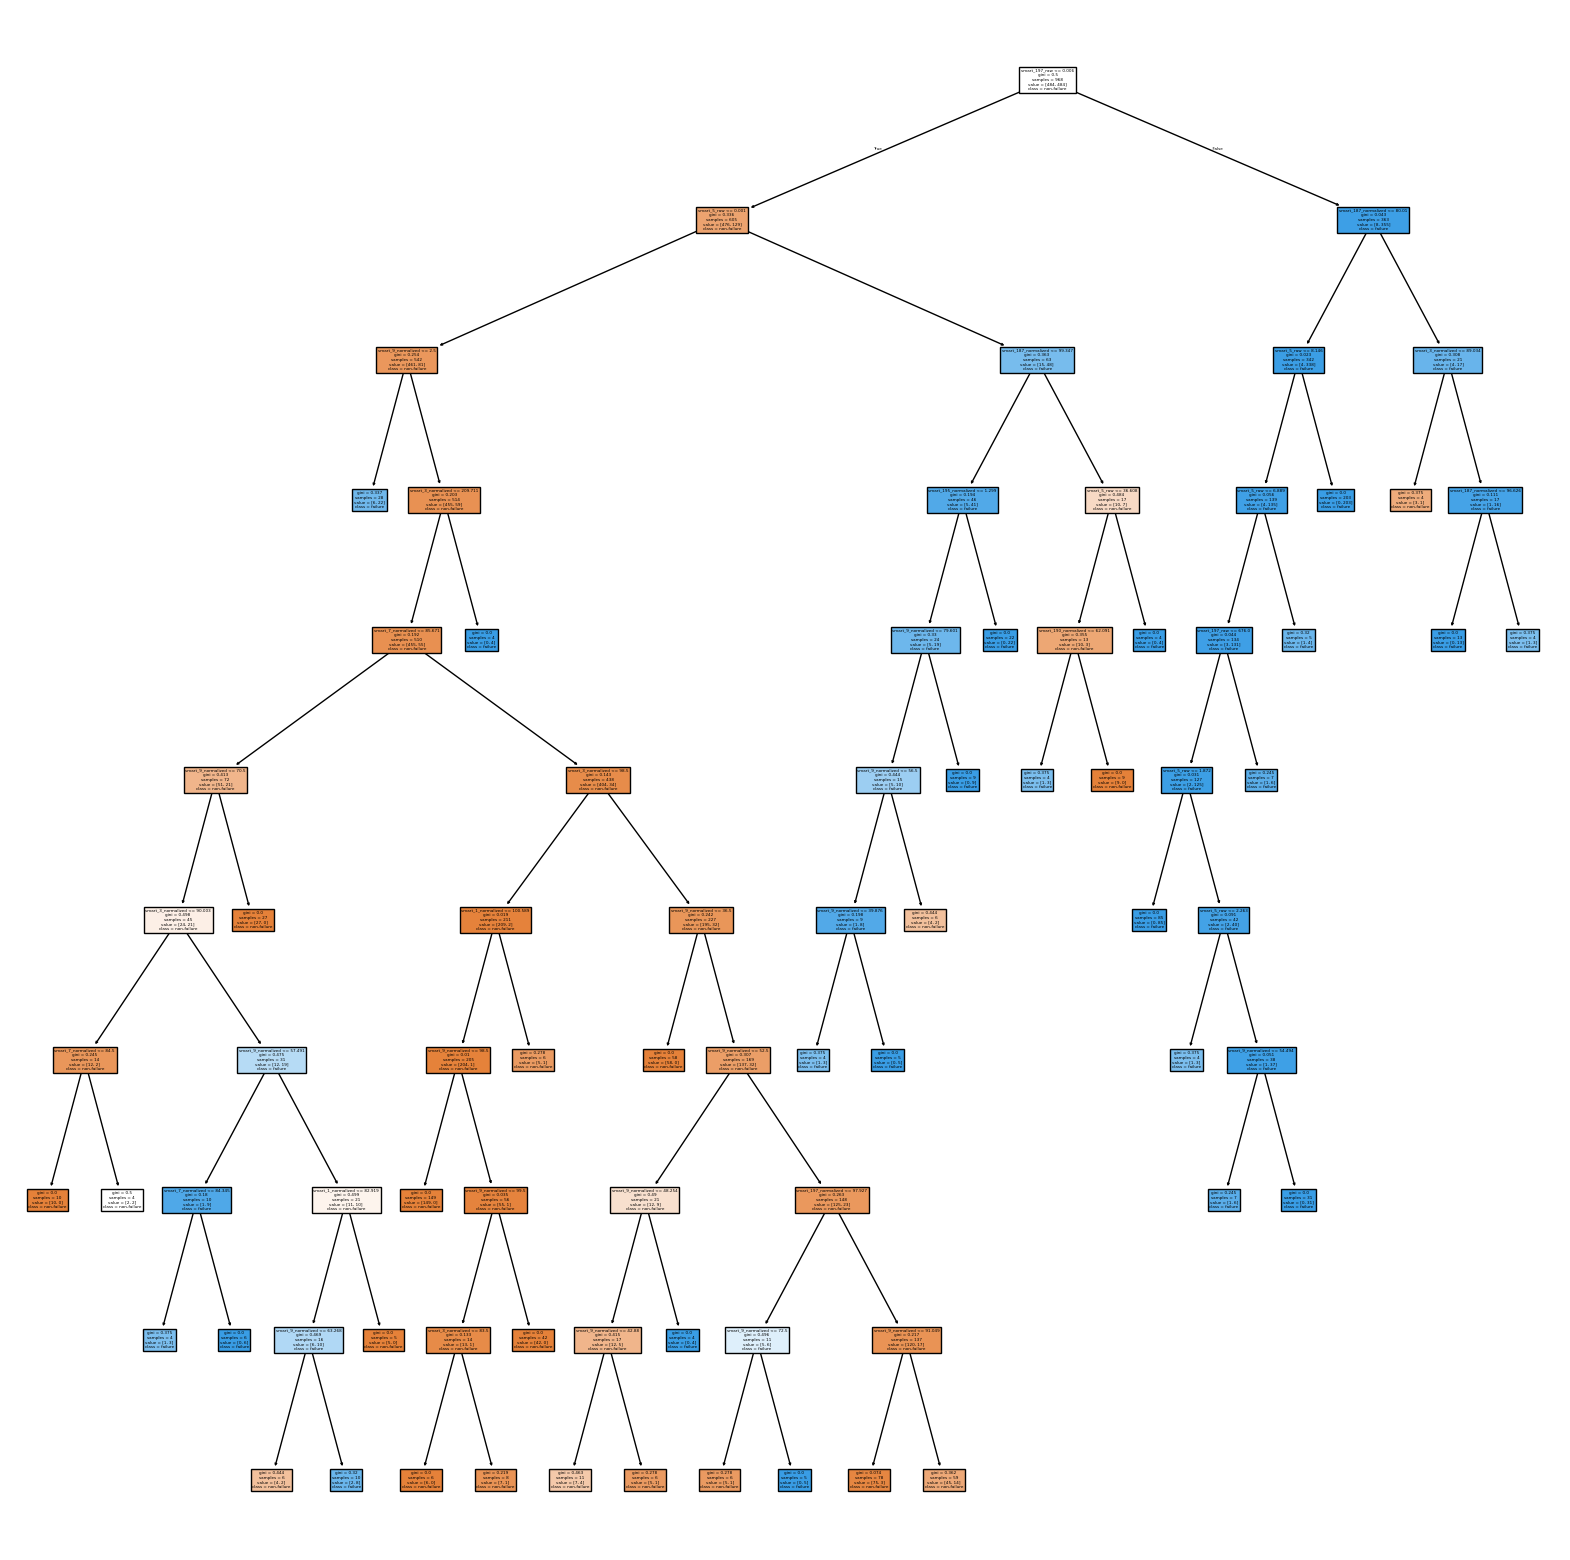

In [104]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['non-failure', 'failure'])
plt.savefig('../reports/figures/decision_tree.png')


## Exploring some dimensionality reduction algorithms

### t-SNE

t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding originally developed by Geoffrey Hinton and Sam Roweis,[1] where Laurens van der Maaten and Hinton proposed the t-distributed variant.[2] It is a nonlinear dimensionality reduction technique for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

 1. Hinton, Geoffrey; Roweis, Sam (January 2002). Stochastic neighbor embedding (PDF). Neural Information Processing Systems.
 2. van der Maaten, L.J.P.; Hinton, G.E. (Nov 2008). "Visualizing Data Using t-SNE" (PDF). Journal of Machine Learning Research. 9: 2579–2605.

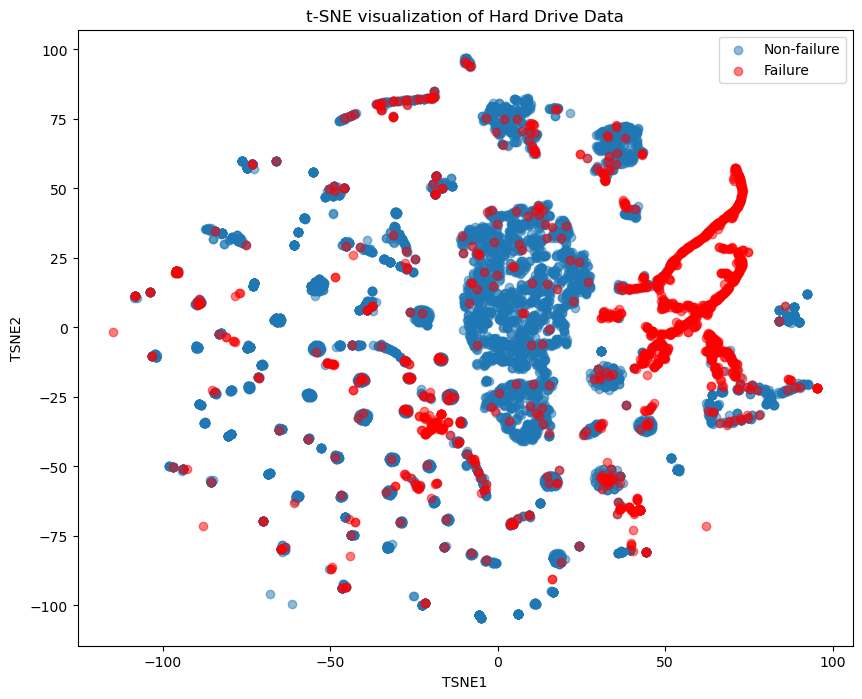

In [107]:
# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data (excluding the 'failure' column)
tsne_results = tsne.fit_transform(SOTA_df.drop(columns=['failure']))

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['failure'] = SOTA_df['failure'].values

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df[tsne_df['failure'] == False]['TSNE1'], tsne_df[tsne_df['failure'] == False]['TSNE2'], label='Non-failure', alpha=0.5)
plt.scatter(tsne_df[tsne_df['failure'] == True]['TSNE1'], tsne_df[tsne_df['failure'] == True]['TSNE2'], label='Failure', alpha=0.5, color='red')
plt.legend()
plt.title('t-SNE visualization of Hard Drive Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

### LDA
Linear discriminant analysis (LDA) is an approach used in supervised machine learning to solve multi-class classification problems. LDA separates multiple classes with multiple features through data dimensionality reduction. This technique is important in data science as it helps optimize machine learning models. [1]
1. IBM. (2024, August 8). What is linear discriminant analysis? https://www.ibm.com/topics/linear-discriminant-analysis 

In [111]:
X = SOTA_df.drop(columns=['failure'])
y = SOTA_df['failure']

n_features = X.shape[1]
n_classes = len(set(y))

# LDA
n_components_lda = min(n_features, n_classes - 1)
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
X_lda = lda.fit_transform(X, y)

print(f"LDA components shape: {X_lda.shape}")

LDA components shape: (8544, 1)


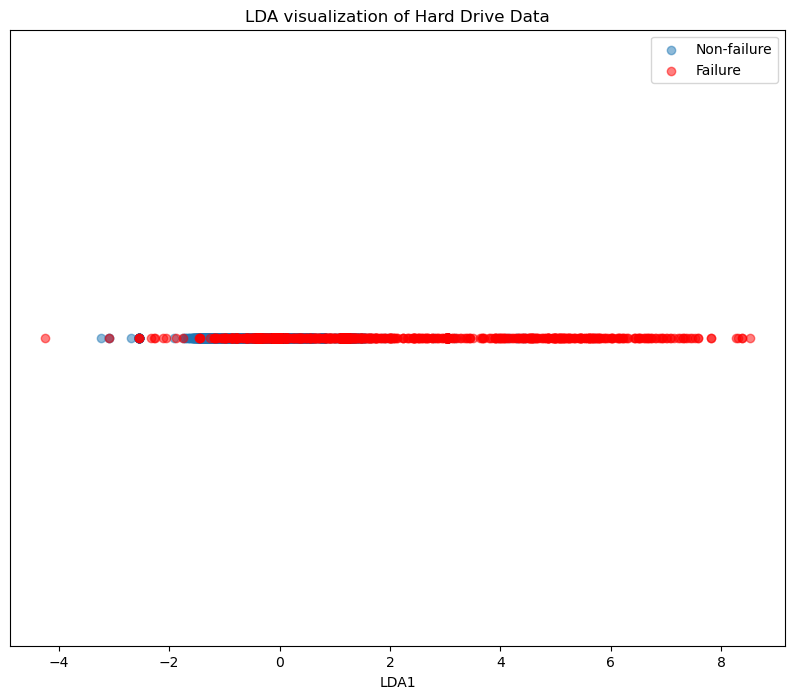

In [112]:
# Create a DataFrame with the LDA results
lda_df = pd.DataFrame(X_lda, columns=['LDA1'])
lda_df['failure'] = y.values

# Plot the LDA results
plt.figure(figsize=(10, 8))
plt.scatter(lda_df[lda_df['failure'] == False]['LDA1'], np.zeros_like(lda_df[lda_df['failure'] == False]['LDA1']), label='Non-failure', alpha=0.5)
plt.scatter(lda_df[lda_df['failure'] == True]['LDA1'], np.zeros_like(lda_df[lda_df['failure'] == True]['LDA1']), label='Failure', alpha=0.5, color='red')
plt.legend()
plt.title('LDA visualization of Hard Drive Data')
plt.xlabel('LDA1')
plt.yticks([])
plt.show()

### KMeans
K-means clustering is an unsupervised learning algorithm used for data clustering, which groups unlabeled data points into groups or clusters.
1. IBM. (2024, August 8). What is k-means clustering? https://www.ibm.com/topics/k-means-clustering

In [113]:
from sklearn.cluster import KMeans

# Initialize the KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model on the original data (excluding the 'failure' column)
kmeans.fit(SOTA_df.drop(columns=['failure']))

# Predict the clusters
clusters = kmeans.predict(SOTA_df.drop(columns=['failure']))

# Add the cluster labels to the original dataframe
SOTA_df['cluster'] = clusters

# Print the first few rows of the dataframe with the cluster labels
print(SOTA_df.head())


        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
123433    False                82.0                91.0               100.0   
23512     False                82.0                85.0               100.0   
56859     False               100.0               100.0               100.0   
121565    False                77.0                92.0               100.0   
49863     False               100.0                 0.0                 0.0   

        smart_5_raw  smart_7_normalized  smart_9_normalized  \
123433          0.0                84.0                53.0   
23512           0.0                96.0                30.0   
56859           0.0               100.0                15.0   
121565          0.0                89.0                88.0   
49863           0.0                 0.0               100.0   

        smart_187_normalized  smart_189_normalized  smart_190_normalized  \
123433                 100.0                   0.0                  71

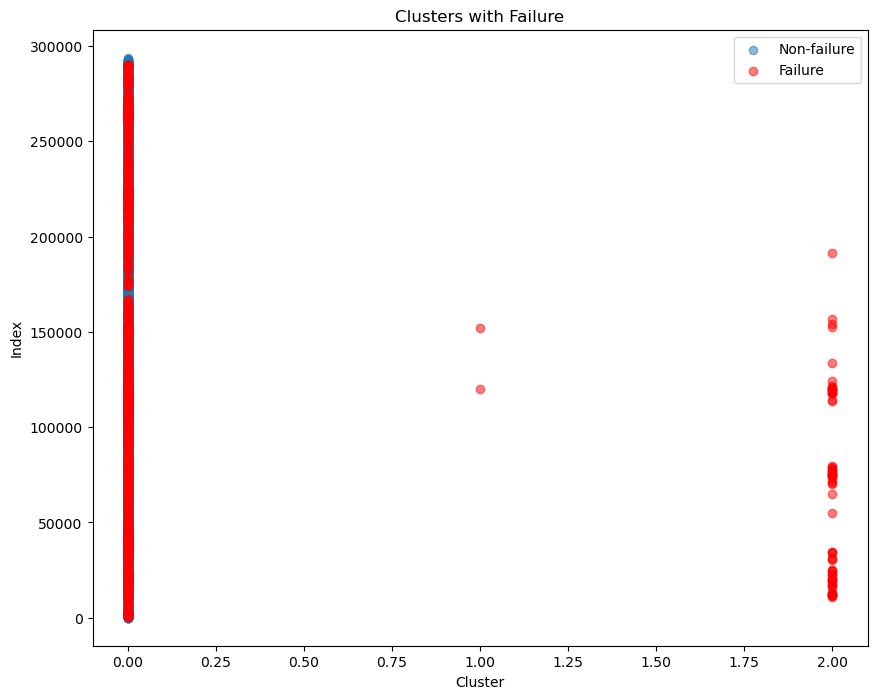

In [114]:
# Plot the clusters with failure
plt.figure(figsize=(10, 8))
plt.scatter(SOTA_df[SOTA_df['failure'] == False]['cluster'], SOTA_df[SOTA_df['failure'] == False].index, label='Non-failure', alpha=0.5)
plt.scatter(SOTA_df[SOTA_df['failure'] == True]['cluster'], SOTA_df[SOTA_df['failure'] == True].index, label='Failure', alpha=0.5, color='red')
plt.legend()
plt.title('Clusters with Failure')
plt.xlabel('Cluster')
plt.ylabel('Index')
plt.show()

### DBSCAN

In [115]:
from sklearn.cluster import DBSCAN

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model on the original data (excluding the 'failure' and 'cluster' columns)
dbscan.fit(SOTA_df.drop(columns=['failure', 'cluster']))

# Predict the clusters
dbscan_labels = dbscan.labels_

# Add the DBSCAN cluster labels to the original dataframe
SOTA_df['dbscan_cluster'] = dbscan_labels

# Print the first few rows of the dataframe with the DBSCAN cluster labels
print(SOTA_df.head())

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
123433    False                82.0                91.0               100.0   
23512     False                82.0                85.0               100.0   
56859     False               100.0               100.0               100.0   
121565    False                77.0                92.0               100.0   
49863     False               100.0                 0.0                 0.0   

        smart_5_raw  smart_7_normalized  smart_9_normalized  \
123433          0.0                84.0                53.0   
23512           0.0                96.0                30.0   
56859           0.0               100.0                15.0   
121565          0.0                89.0                88.0   
49863           0.0                 0.0               100.0   

        smart_187_normalized  smart_189_normalized  smart_190_normalized  \
123433                 100.0                   0.0                  71

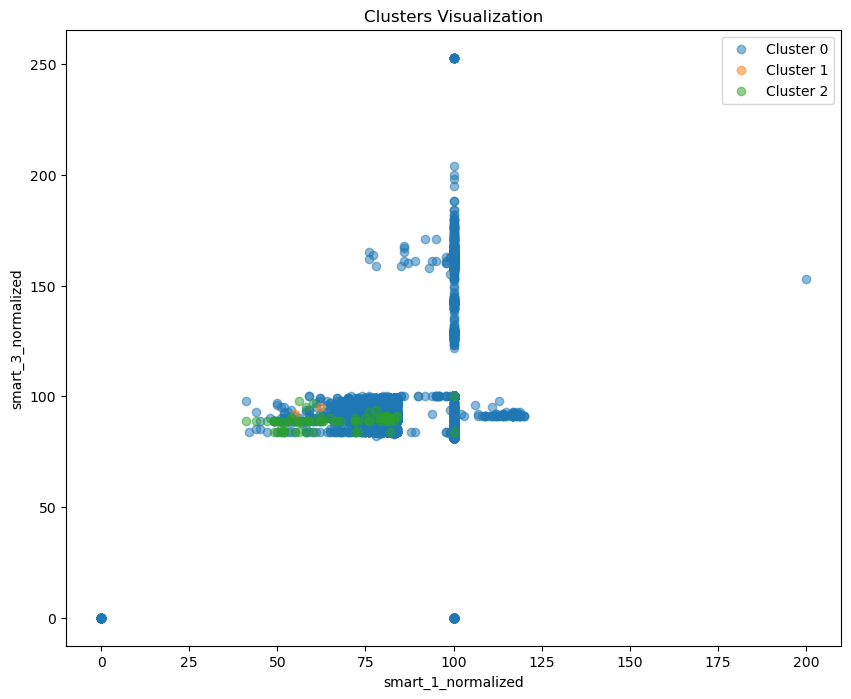

In [116]:
plt.figure(figsize=(10, 8))
plt.scatter(SOTA_df[SOTA_df['cluster'] == 0]['smart_1_normalized'], SOTA_df[SOTA_df['cluster'] == 0]['smart_3_normalized'], label='Cluster 0', alpha=0.5)
plt.scatter(SOTA_df[SOTA_df['cluster'] == 1]['smart_1_normalized'], SOTA_df[SOTA_df['cluster'] == 1]['smart_3_normalized'], label='Cluster 1', alpha=0.5)
plt.scatter(SOTA_df[SOTA_df['cluster'] == 2]['smart_1_normalized'], SOTA_df[SOTA_df['cluster'] == 2]['smart_3_normalized'], label='Cluster 2', alpha=0.5)
plt.legend()
plt.title('Clusters Visualization')
plt.xlabel('smart_1_normalized')
plt.ylabel('smart_3_normalized')
plt.show()